# Formula 1 Development Analysis: Impact of ATR Regulations
**Project Objective:** Modelling how Aerodynamic Testing Restrictions (ATR) and Cost Cap regulations which was implemented after the year 2019 affects the competition, pure car performances(qualifying lap times), in season development rates to predict future performance trends in the sport using Machine Learning.

### Methodology
1. **Data Collection:** Taking the data of qualifying sessions from 2017 to 2024
2. **Preprocessing:** Converting lap times to seconds and filtering out wet sessions(filtering environmental noise) to isolate aerodynamic performance.
3. **EDA (Exploratory Data Analysis):** Visualizing the "Gap to Pole" percentage trends to understand the data.
4. **Mathematical Modeling:** Using statistical methods to quantifyin the effect of the regulations and performance trends.
5. **Machine Learning:** Using Random Forest to analyze Feature Importance and predict 2025 development trends.

**DATA COLLECTION**

1


In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind
from sklearn.metrics import r2_score

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 12
    
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [230]:
#Function for changing the time format to total seconds for calculations
def time_to_seconds(time_str):
    try:
        if pd.isna(time_str) or str(time_str).strip() == '': return np.nan
        parts = str(time_str).split(':')
        if len(parts) == 2:
            return float(parts[0]) * 60 + float(parts[1])
        return float(parts[0])
    except:
        return np.nan


cleaning the data

In [231]:
# eliminating the rainy qualifying sessions since they are not a representative of the pure aerodynamic performance and would create noise in the analysis.(In Formula 1 rainy sessions generally lead to unpredictable results as driver skill and external factors play a larger role than car aerodynamics)
WET_QUALIFYING_SESSIONS = [
    (2017, 'Italian Grand Prix'),
    (2018, 'Hungarian Grand Prix'), (2018, 'Belgian Grand Prix'), (2018, 'Japanese Grand Prix'),
    (2019, 'German Grand Prix'),
    (2020, 'Styrian Grand Prix'), (2020, 'Turkish Grand Prix'),
    (2021, 'Emilia Romagna Grand Prix'), (2021, 'Belgian Grand Prix'), (2021, 'Russian Grand Prix'), (2021, 'Turkish Grand Prix'),
    (2022, 'Emilia Romagna Grand Prix'), (2022, 'Canadian Grand Prix'), (2022, 'British Grand Prix'), (2022, 'Singapore Grand Prix'), (2022, 'Japanese Grand Prix'), (2022, 'São Paulo Grand Prix'),
    (2023, 'Canadian Grand Prix'), (2023, 'British Grand Prix'), (2023, 'Belgian Grand Prix'), (2023, 'Dutch Grand Prix'),
    (2024, 'Chinese Grand Prix'), (2024, 'Canadian Grand Prix'), (2024, 'British Grand Prix')
]
# Manually cleaning data of Logan Sergant since he had an exceptional gap due to a spin in qualifying session which is a  driver error not related to the car.
# This outlier skews the analysis of the car performance therefore will be removed.
DRIVER_OUTLIERS = [
    (2023, 'Saudi Arabian Grand Prix', 858) 
]

In [232]:
try:
    races = pd.read_csv('data/races.csv')
    qualifying = pd.read_csv('data/qualifying.csv')
    constructors = pd.read_csv('data/constructors.csv')
    print("reading is completed ")
except FileNotFoundError:
    print("error: data files not found")

reading is completed 


**PREPROCESSING**

2

In [ ]:
#Changing the format of the data for processing
target_years = [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
races = races[races['year'].isin(target_years)][['raceId', 'year', 'name', 'round', 'date']]

df = qualifying.merge(races, on='raceId', how='inner')
df = df.merge(constructors[['constructorId', 'name']], on='constructorId', how='left')
df.rename(columns={'name_y': 'team', 'name_x': 'gp_name'}, inplace=True)

try:
    con_standings = pd.read_csv('data/constructor_standings.csv')
    con_standings = con_standings.merge(races[['raceId', 'year']], on='raceId', how='inner')
except FileNotFoundError:
    print("Warning: constructor_standings.csv not found!")

print(f"total amount of sessions {len(df)}")
for year, gp_name in WET_QUALIFYING_SESSIONS:
    df = df[~((df['year'] == year) & (df['gp_name'] == gp_name))]

for year, gp_name, driver_id in DRIVER_OUTLIERS:
    df = df[~((df['year'] == year) & (df['gp_name'] == gp_name) & (df['driverId'] == driver_id))]
print(f"After clearing {len(df)}")

df['q1_sec'] = df['q1'].apply(time_to_seconds)
df['q2_sec'] = df['q2'].apply(time_to_seconds)
df['q3_sec'] = df['q3'].apply(time_to_seconds)
df['best_time'] = df[['q1_sec', 'q2_sec', 'q3_sec']].min(axis=1)

df = df.dropna(subset=['best_time'])
df.head()

Constructor Standings 'year' bilgisiyle güncellendi.
total amount of sessions 3374
After clearing 2893


,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3,year,gp_name,round,date,team,q1_sec,q2_sec,q3_sec,best_time
0,7140,969,1,131,44,1,1:24.191,1:23.251,1:22.188,2017,Australian Grand Prix,1,2017-03-26,Mercedes,84.191,83.251,82.188,82.188
1,7141,969,20,6,5,2,1:25.210,1:23.401,1:22.456,2017,Australian Grand Prix,1,2017-03-26,Ferrari,85.210,83.401,82.456,82.456
2,7142,969,822,131,77,3,1:24.514,1:23.215,1:22.481,2017,Australian Grand Prix,1,2017-03-26,Mercedes,84.514,83.215,82.481,82.481
3,7143,969,8,6,7,4,1:24.352,1:23.376,1:23.033,2017,Australian Grand Prix,1,2017-03-26,Ferrari,84.352,83.376,83.033,83.033
4,7144,969,830,9,33,5,1:24.482,1:24.092,1:23.485,2017,Australian Grand Prix,1,2017-03-26,Red Bull,84.482,84.092,83.485,83.485


standartize team names

In [234]:
# Some teams have changed names over years. We standardize them.

team_mapping = {
    'Force India': 'Aston Martin', 'Racing Point': 'Aston Martin', 'Aston Martin': 'Aston Martin',
    'Sauber': 'Kick Sauber', 'Alfa Romeo': 'Kick Sauber', 'Kick Sauber': 'Kick Sauber',
    'Renault': 'Alpine', 'Alpine': 'Alpine',
    'Toro Rosso': 'RB', 'AlphaTauri': 'RB', 'RB': 'RB',
    'Haas F1 Team': 'Haas', 'Haas': 'Haas',
    'McLaren': 'McLaren', 'Mercedes': 'Mercedes', 'Ferrari': 'Ferrari',
    'Red Bull': 'Red Bull', 'Williams': 'Williams'
}
df['team'] = df['team'].map(team_mapping).fillna(df['team'])

**VISUALIZING TOP TEAMS(EDA)**

3

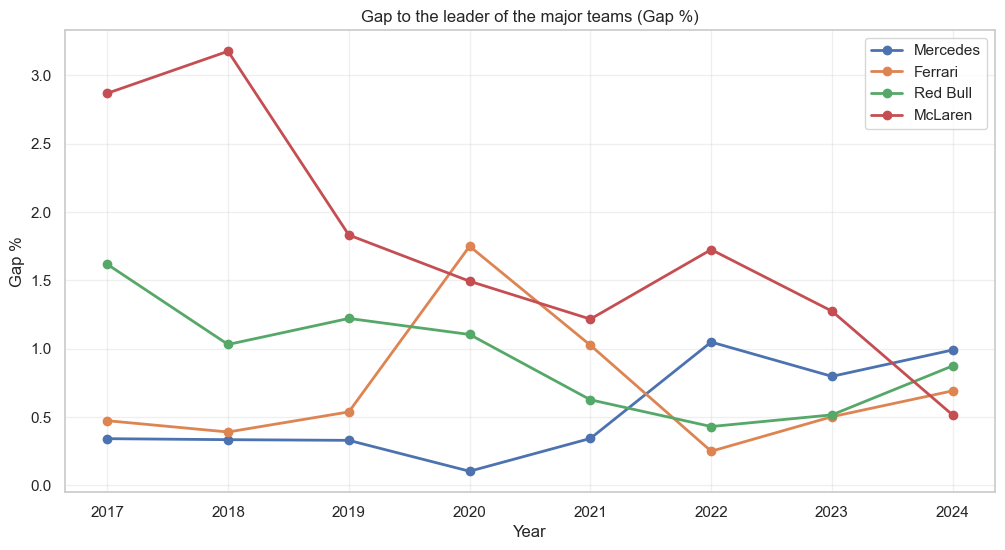

   year          team  gap_percent               period
0  2017        Alpine     2.685439  Pre-ATR (2017-2020)
1  2017  Aston Martin     2.400116  Pre-ATR (2017-2020)
2  2017       Ferrari     0.472712  Pre-ATR (2017-2020)
3  2017          Haas     3.710632  Pre-ATR (2017-2020)
4  2017   Kick Sauber     5.025400  Pre-ATR (2017-2020)


In [235]:

pole_times = df.groupby(['year', 'gp_name'])['best_time'].min().reset_index()
pole_times.rename(columns={'best_time': 'pole_time'}, inplace=True)
df = df.merge(pole_times, on=['year', 'gp_name'], how='left')
df['gap_percent'] = ((df['best_time'] - df['pole_time']) / df['pole_time']) * 100


yearly_stats = df.groupby(['year', 'team'])['gap_percent'].mean().reset_index()

yearly_stats['period'] = yearly_stats['year'].apply(lambda x: 'Pre-ATR (2017-2020)' if x < 2021 else 'Post-ATR (2021-2024)')

top_teams = ['Mercedes', 'Ferrari', 'Red Bull', 'McLaren']
plt.figure(figsize=(12, 6))

for team in top_teams:
    team_data = yearly_stats[yearly_stats['team'] == team]
    plt.plot(team_data['year'], team_data['gap_percent'], marker='o', linewidth=2, label=team)

plt.title("Gap to the leader of the major teams (Gap %)")
plt.ylabel("Gap %")
plt.xlabel("Year")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(yearly_stats.head())

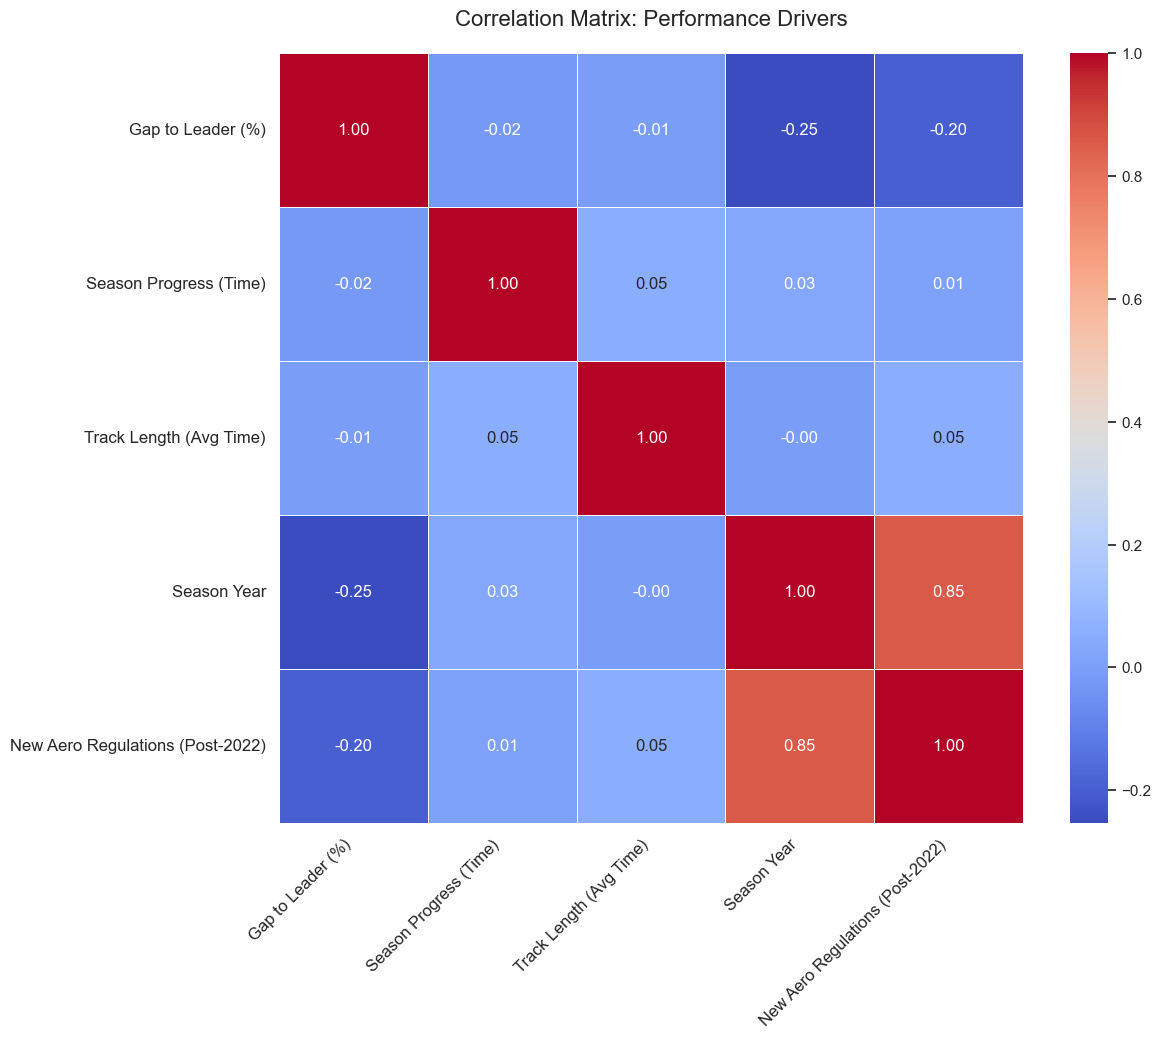

In [ ]:
# corelation heatmap.
import seaborn as sns
import matplotlib.pyplot as plt


if 'avg_lap_time' not in df.columns:
    track_stats = df.groupby('gp_name')['pole_time'].mean().reset_index(name='avg_lap_time')
    df = df.merge(track_stats, on='gp_name', how='left')

if 'season_progress' not in df.columns:
    df['season_progress'] = df.groupby('year')['round'].transform(lambda x: x / x.max())

heatmap_data = df[['gap_percent', 'season_progress', 'avg_lap_time', 'year']].copy()
heatmap_data['is_new_era'] = heatmap_data['year'].apply(lambda x: 1 if x >= 2022 else 0)

map = {
    'gap_percent': 'Gap to Leader (%)',
    'season_progress': 'Season Progress (Time)',
    'avg_lap_time': 'Track Length (Avg Time)',
    'year': 'Season Year',
    'is_new_era': 'New Aero Regulations (Post-2022)'
}

heatmap_data_clean = heatmap_data.rename(columns=map)

plt.figure(figsize=(12, 10))

sns.heatmap(
    heatmap_data_clean.corr(), 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    linewidths=0.5,
    annot_kws={"size": 12} 
)

plt.title("Correlation Matrix: Performance Drivers", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

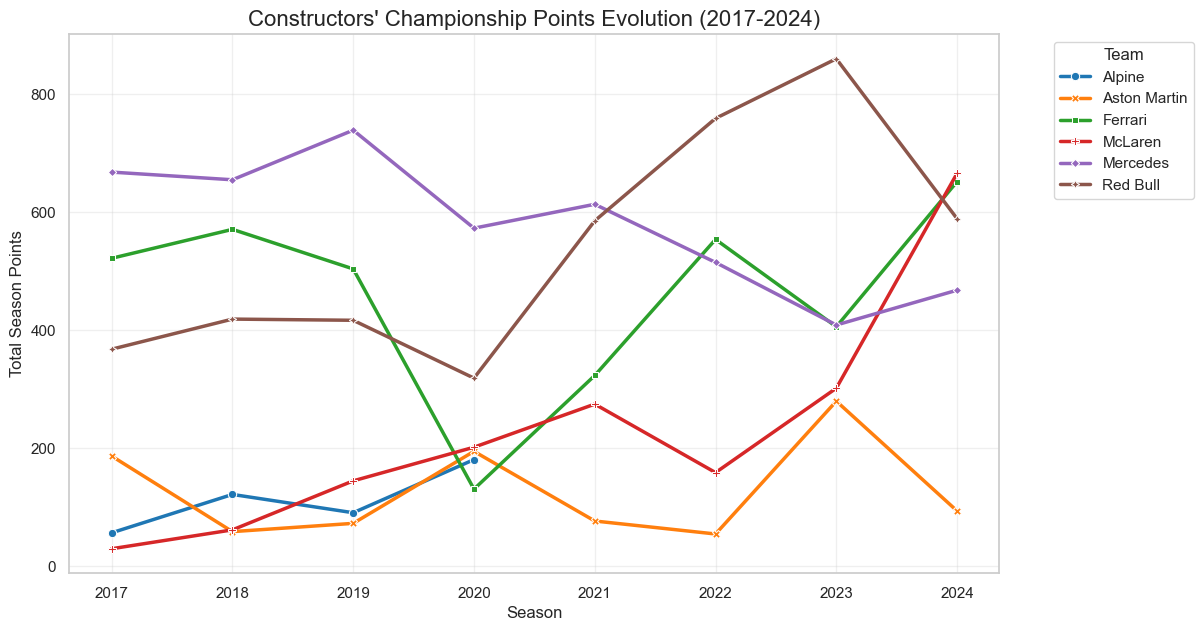

In [237]:
#constructor points for top teams
import seaborn as sns
import matplotlib.pyplot as plt


con_standings = pd.read_csv('data/constructor_standings.csv')
constructors = pd.read_csv('data/constructors.csv')


points_df = con_standings.merge(races[['raceId', 'year']], on='raceId', how='inner')
points_df = points_df.merge(constructors[['constructorId', 'name']], on='constructorId', how='left')


points_df['team'] = points_df['name'].map(team_mapping).fillna(points_df['name'])


final_points = points_df[points_df['year'].isin([2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])].copy()

season_points = final_points.groupby(['year', 'team'])['points'].max().reset_index()

plt.figure(figsize=(12, 7))


focus_teams = ['Mercedes', 'Red Bull', 'Ferrari', 'McLaren', 'Aston Martin', 'Alpine']
plot_data = season_points[season_points['team'].isin(focus_teams)]

sns.lineplot(
    data=plot_data, 
    x='year', 
    y='points', 
    hue='team', 
    style='team', 
    markers=True, 
    dashes=False,
    linewidth=2.5,
    palette='tab10'
)

plt.title("Constructors' Championship Points Evolution (2017-2024)", fontsize=16)
plt.ylabel("Total Season Points", fontsize=12)
plt.xlabel("Season", fontsize=12)
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

**MATHEMATICAL MODELLING**

In [ ]:
#slope and r2

if 'round' not in df.columns:
    df['round'] = df.groupby('year').cumcount() + 1

def calculate_metrics(dataframe):
    results = []
    for team in dataframe['team'].unique():
        for year in dataframe['year'].unique():
            team_data = dataframe[(dataframe['team'] == team) & (dataframe['year'] == year)]
            if len(team_data) > 5:
                slope, intercept, r_val, p_val, std = linregress(team_data['round'], team_data['gap_percent'])
                results.append({
                    'Team': team, 'Year': year,
                    'Development_Slope': slope,
                    'R_Squared': r_val**2,
                    'P_Value': p_val
                })
    return pd.DataFrame(results)

dev_stats_df = calculate_metrics(df)
print("Mathematical Model (Slope & R2) Calculated.")
display(dev_stats_df.sort_values(by='Development_Slope').head())

Mathematical Model (Slope & R2) Calculated.


,Team,Year,Development_Slope,R_Squared,P_Value
43,RB,2020,-0.110136,0.540951,0.000004
59,McLaren,2017,-0.096777,0.324563,0.000189
70,Kick Sauber,2020,-0.092550,0.356898,0.000491
68,Kick Sauber,2018,-0.091137,0.410251,0.000026
58,Alpine,2020,-0.085242,0.422186,0.000102


**HYPOTHESIS TESTING** 


Statistical comparison of 2 years and visualization


--- Statistical Test Results: 2021 vs 2022 Regulations ---
T-Statistic: -0.6821
P-Value: 4.9542e-01
FAIL TO REJECT Null Hypothesis.
No significant difference found in performance gaps.


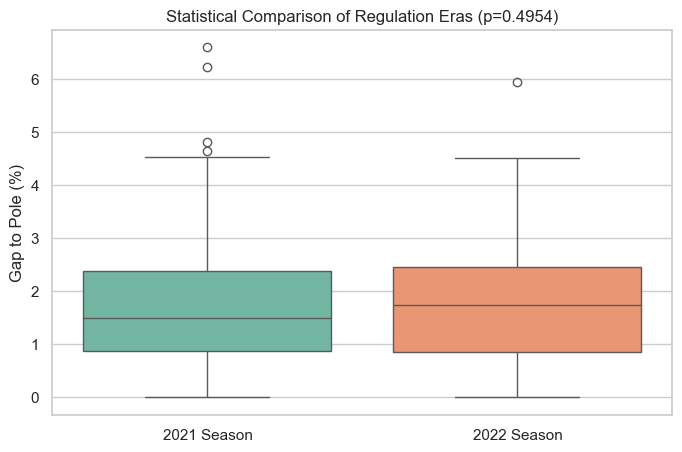

In [ ]:
#HYPOTHESIS TESTING: REGULATION IMPACT BETWEEN YEARS 2021 AND 2022(T-TEST) 

gap_2021 = df[df['year'] == 2021]['gap_percent'].dropna()
gap_2022 = df[df['year'] == 2022]['gap_percent'].dropna()

t_stat, p_val_ttest = ttest_ind(gap_2021, gap_2022, equal_var=False)

print("\n--- Statistical Test Results: 2021 vs 2022 Regulations ---")
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_val_ttest:.4e}")

alpha = 0.05
if p_val_ttest < alpha:
    print("REJECT Null Hypothesis.")
    print("There is a statistically significant difference in performance gaps")
else:
    print("FAIL TO REJECT Null Hypothesis.")
    print("No significant difference found in performance gaps.")

plt.figure(figsize=(8, 5))

sns.boxplot(data=[gap_2021.values, gap_2022.values], palette="Set2") 

plt.xticks([0, 1], ['2021 Season', '2022 Season'])
plt.ylabel('Gap to Pole (%)')
plt.title(f'Statistical Comparison of Regulation Eras (p={p_val_ttest:.4f})')
plt.show()

hypothesis testing of different eras

--- Era Performance Comparison ---
1. Unrestricted Era (2017-2020) Mean Gap: 2.20%
2. Transition Year (2021) Mean Gap:       1.69%
3. New Regulations (2022-2024) Mean Gap:  1.49%

--- T-Test: Unrestricted (17-20) vs New Era (22-24) ---
P-Value: 6.8629e-34
Conclusion: REJECT Null Hypothesis. The regulation change created a statistically significant difference.


C:\Users\yunus\AppData\Local\Temp\ipykernel_15964\3204871933.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Era', y='Gap (%)', data=plot_data, palette="viridis")


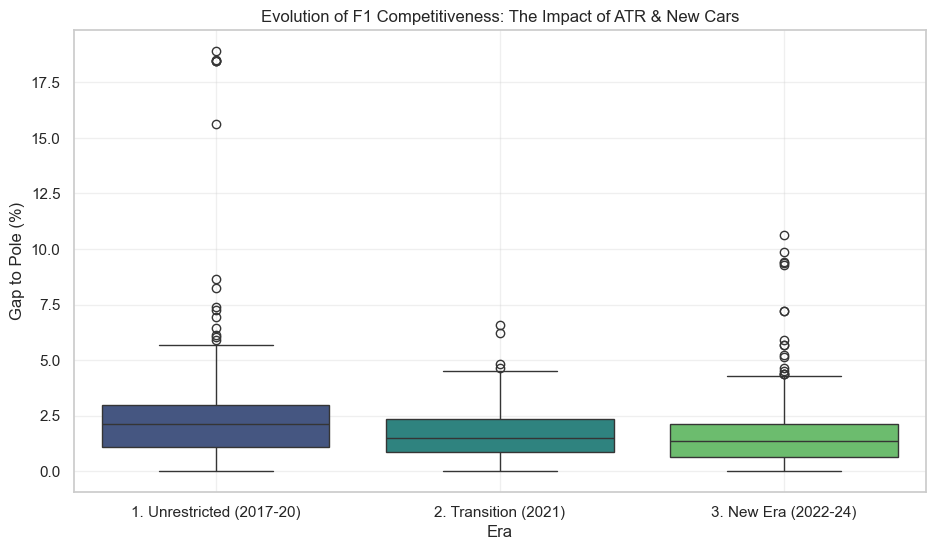

In [240]:

era_unrestricted = df[df['year'].between(2017, 2020)]['gap_percent'].dropna()

era_transition = df[df['year'] == 2021]['gap_percent'].dropna()

era_new = df[df['year'] >= 2022]['gap_percent'].dropna()

print(f"--- Era Performance Comparison ---")
print(f"1. Unrestricted Era (2017-2020) Mean Gap: {era_unrestricted.mean():.2f}%")
print(f"2. Transition Year (2021) Mean Gap:       {era_transition.mean():.2f}%")
print(f"3. New Regulations (2022-2024) Mean Gap:  {era_new.mean():.2f}%")

t_stat, p_val = ttest_ind(era_unrestricted, era_new, equal_var=False)
print(f"\n--- T-Test: Unrestricted (17-20) vs New Era (22-24) ---")
print(f"P-Value: {p_val:.4e}")

if p_val < 0.05:
    print("Conclusion: REJECT Null Hypothesis. The regulation change created a statistically significant difference.")
else:
    print("Conclusion: FAIL TO REJECT. No significant difference found.")

plt.figure(figsize=(11, 6))

plot_data = pd.DataFrame({
    'Gap (%)': pd.concat([era_unrestricted, era_transition, era_new]),
    'Era': ['1. Unrestricted (2017-20)'] * len(era_unrestricted) + 
           ['2. Transition (2021)'] * len(era_transition) + 
           ['3. New Era (2022-24)'] * len(era_new)
})

sns.boxplot(x='Era', y='Gap (%)', data=plot_data, palette="viridis")

plt.title('Evolution of F1 Competitiveness: The Impact of ATR & New Cars')
plt.ylabel('Gap to Pole (%)')
plt.grid(True, alpha=0.3)
plt.show()

**ENRICHMENT WITH IN SEASON DEVELOPMENT**


relationship between the atr and in season development

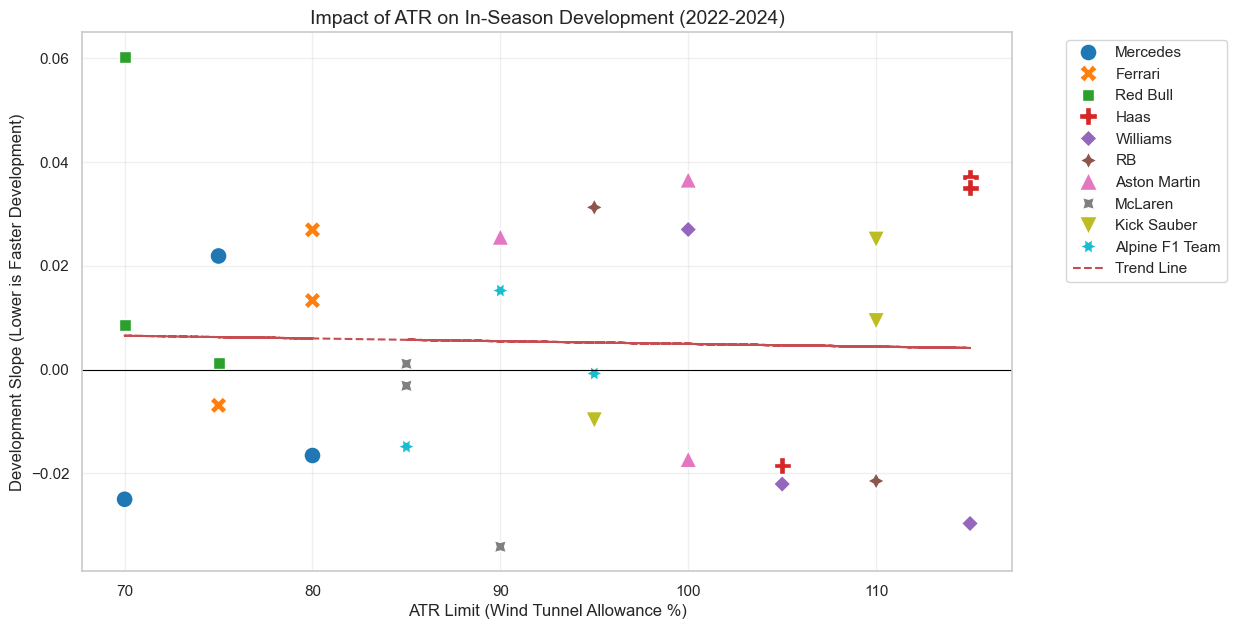

In [241]:

last_races_ids = races.sort_values(['year', 'round']).groupby('year')['raceId'].tail(1)

season_end = con_standings[con_standings['raceId'].isin(last_races_ids)].copy()
season_end = season_end.merge(races[['raceId', 'year']], on='raceId', how='left')
season_end = season_end.merge(constructors[['constructorId', 'name']], on='constructorId', how='left')

season_end['team'] = season_end['name'].map(team_mapping).fillna(season_end['name'])

season_end['atr_year'] = season_end['year'] + 1 

if 'dev_stats_df' not in globals():
    print("HATA: 'dev_stats_df' bulunamadı. Lütfen 4. Adım (Matematiksel Modelleme) kodunu çalıştır.")
else:
    ml_data = dev_stats_df.merge(
        season_end[['atr_year', 'team', 'position']], 
        left_on=['Year', 'Team'], 
        right_on=['atr_year', 'team'], 
        how='inner'
    )

    def atr_limit(row):
        y, p = row['Year'], row['position']
        if y < 2021: return 100.0 
        if y == 2021: return 90 + (p - 1) * 2.5 
        return 70 + (p - 1) * 5

    ml_data['atr_limit'] = ml_data.apply(atr_limit, axis=1)

    plt.figure(figsize=(12, 7))
    plot_data = ml_data[ml_data['Year'] >= 2022].copy()

    sns.scatterplot(
        data=plot_data, x='atr_limit', y='Development_Slope', 
        hue='Team', style='Team', s=150, palette='tab10'
    )


    if len(plot_data) > 1:
        z = np.polyfit(plot_data['atr_limit'], plot_data['Development_Slope'], 1)
        p = np.poly1d(z)
        plt.plot(plot_data['atr_limit'], p(plot_data['atr_limit']), "r--", label='Trend Line')

    plt.axhline(0, color='black', linestyle='-', linewidth=0.8)
    plt.title("Impact of ATR on In-Season Development (2022-2024)", fontsize=14)
    plt.xlabel("ATR Limit (Wind Tunnel Allowance %)", fontsize=12)
    plt.ylabel("Development Slope (Lower is Faster Development)", fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.show()



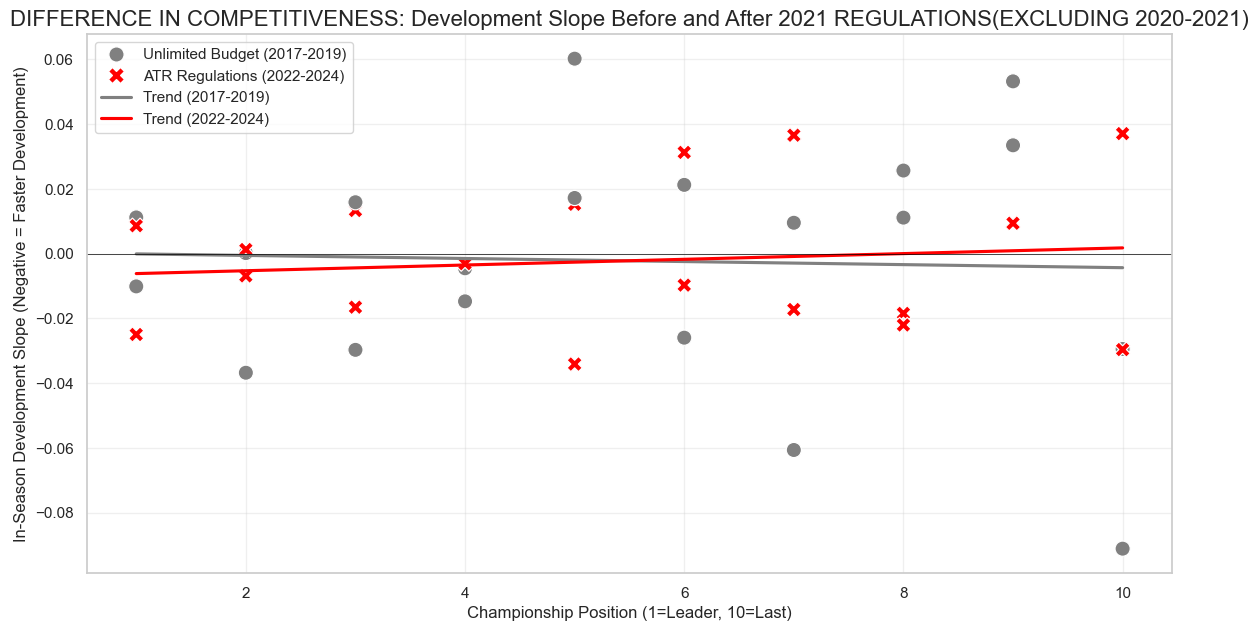

Old Era (2017-19) Correlation: -0.038
New Era (2022-24) Correlation: 0.117


In [242]:

target_years_clean = [2017, 2018, 2019, 2022, 2023, 2024]
clean_df = full_analysis_df[full_analysis_df['year'].isin(target_years_clean)].copy()

clean_df['era_clean'] = clean_df['year'].apply(
    lambda x: 'Unlimited Budget (2017-2019)' if x < 2020 else 'ATR Regulations (2022-2024)'
)

plt.figure(figsize=(14, 7))


sns.scatterplot(
    data=clean_df,
    x='champ_pos',
    y='dev_slope',
    hue='era_clean',
    style='era_clean',
    s=120, 
    palette={'Unlimited Budget (2017-2019)': 'gray', 'ATR Regulations (2022-2024)': 'red'} 
)


sns.regplot(
    data=clean_df[clean_df['era_clean'] == 'Unlimited Budget (2017-2019)'],
    x='champ_pos', y='dev_slope', scatter=False, color='gray', label='Trend (2017-2019)', ci=None
)

sns.regplot(
    data=clean_df[clean_df['era_clean'] == 'ATR Regulations (2022-2024)'],
    x='champ_pos', y='dev_slope', scatter=False, color='red', label='Trend (2022-2024)', ci=None
)

plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
plt.title("DIFFERENCE IN COMPETITIVENESS: Development Slope Before and After 2021 REGULATIONS(EXCLUDING 2020-2021)", fontsize=16)
plt.xlabel("Championship Position (1=Leader, 10=Last)")
plt.ylabel("In-Season Development Slope (Negative = Faster Development)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

era_old = clean_df[clean_df['year'] < 2020]
era_new = clean_df[clean_df['year'] > 2021]

corr_old = era_old['champ_pos'].corr(era_old['dev_slope'])
corr_new = era_new['champ_pos'].corr(era_new['dev_slope'])

print(f"Old Era (2017-19) Correlation: {corr_old:.3f}")
print(f"New Era (2022-24) Correlation: {corr_new:.3f}")

13

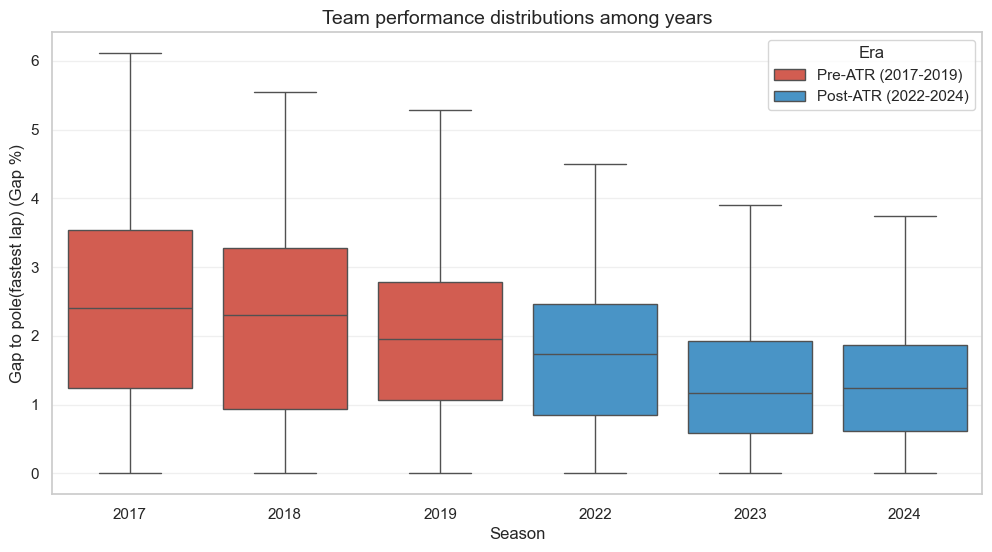

In [243]:
import seaborn as sns
import matplotlib.pyplot as plt

target_years_box = [2017, 2018, 2019, 2022, 2023, 2024]
box_data = df[df['year'].isin(target_years_box)].copy()


def get_era(year):
    if year < 2020: return 'Pre-ATR (2017-2019)'
    if year > 2021: return 'Post-ATR (2022-2024)'
    return 'Other'

box_data['Era'] = box_data['year'].apply(get_era)

plt.figure(figsize=(12, 6))


sns.boxplot(
    data=box_data, 
    x='year', 
    y='gap_percent', 
    hue='Era',
    palette={'Pre-ATR (2017-2019)': '#e74c3c', 'Post-ATR (2022-2024)': '#3498db'},
    showfliers=False
)

plt.title("Team performance distributions among years", fontsize=14)
plt.ylabel("Gap to pole(fastest lap) (Gap %)", fontsize=12)
plt.xlabel("Season", fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Era')
plt.show()